In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
pyo.init_notebook_mode()
from imblearn.over_sampling import SMOTE
import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
import os

from sklearn.metrics import classification_report,confusion_matrix,f1_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('figure',figsize=(17,13))
sns.set_context('paper',font_scale=2)

def set_seed(seed=31415):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [2]:
datasets = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
datasets.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
datasets= datasets.drop(["id"], axis=1)

In [5]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [6]:
datasets.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [7]:
datasets.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
# datasets['bmi'].fillna(datasets['bmi'].mean(), inplace=True)
# datasets
from sklearn.impute import SimpleImputer 
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(datasets[['bmi']])
datasets['bmi'] = imr.transform(datasets[['bmi']]).ravel()

In [9]:
datasets

gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level        bmi   smoking_status  stroke  
0             Urban             228.69  36.600000  formerly smoked       1  
1             Rural             202.21  28.893237     never smoked       1  
2             Rural             105.92  32.500000     never smoked       1  
3             Urban             171.23  34.400000           smokes       1  
4             Rural             174.12  24.000000     never smoked       1  
...             ...                ...        ...              ...     ...  
5105          Urban              83.75  28.893237     never smoked       0  
5106          Urban             125.20  40.000000     never smoked       0  
5107          Rural              82.99  30.600000     never smoked       0  
5108          Rural             166.29  25.600000  formerly smoked       0  
5109          Urban              85.28  26.200000          Unknown       0  

[5110 rows x 11 columns]

In [10]:
fig = ex.pie(datasets,names='stroke')
fig.update_layout(title='<b>Proporsi Sampel Stroke<b>')
fig.show()

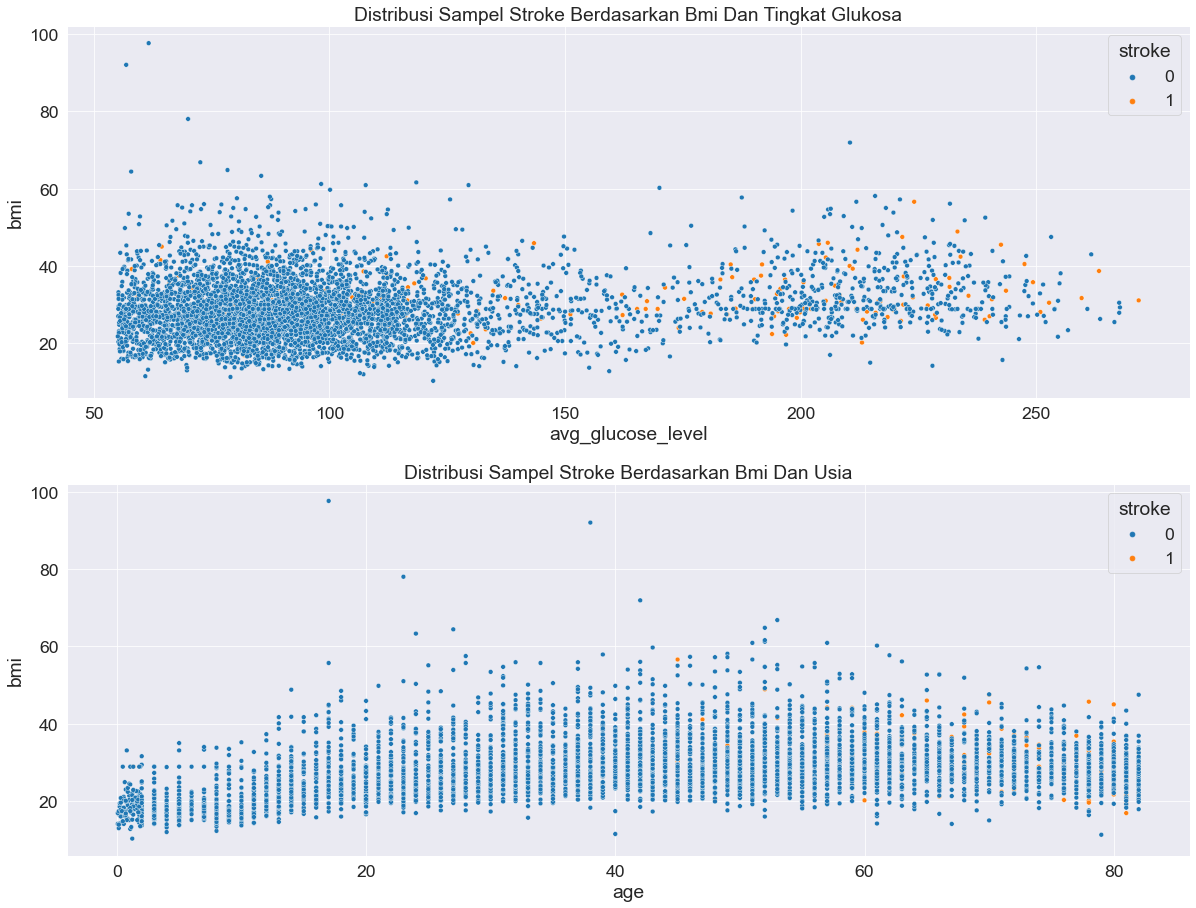

In [11]:
plt.subplot(2,1,1)
plt.title('Distribusi Sampel Stroke Berdasarkan Bmi Dan Tingkat Glukosa')
sns.scatterplot(x=datasets['avg_glucose_level'],y=datasets['bmi'],hue=datasets['stroke'])
plt.subplot(2,1,2)
plt.title('Distribusi Sampel Stroke Berdasarkan Bmi Dan Usia')
sns.scatterplot(x=datasets['age'],y=datasets['bmi'],hue=datasets['stroke'])
plt.tight_layout()
plt.show()

In [12]:
stroke_population = datasets.query('stroke ==1').copy()

fig = make_subplots(
    rows=2, cols=2,subplot_titles=('','<b>Distribusi Usia Wanita<b>','<b>Distribusi Usia Pria<b>','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2}       ,{"type": "histogram"}] ,
           [None                               ,{"type": "histogram"}]            ,                                      
          ]
)

fig.add_trace(
    go.Pie(values=stroke_population.gender.value_counts().values,labels=['<b>Female<b>','<b>Male<b>','<b>Other<b>'],hole=0.3,pull=[0,0.08,0.3],marker_colors=['pink','lightblue','green'],textposition='inside'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=stroke_population.query('gender=="Female"').age,marker= dict(color='pink'),name='Female Ages'
    ),
    row=1, col=2
)


fig.add_trace(
    go.Histogram(
        x=stroke_population.query('gender=="Male"').age,marker= dict(color='lightblue'),name='Male Ages'
    ),
    row=2, col=2
)


fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Sample seseorang yang positive stroke berdasarkan kelamin dan usia<b>",
)

fig.show()

In [13]:
stroke_population = datasets.query('stroke ==1').copy()

fig = make_subplots(
    rows=2, cols=2,subplot_titles=('<b>Proportion Of Different Work Types<b>','<b>Proportion Of Married Individuals<b>','<b>Proportion Of Residence Type<b>','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "pie","rowspan": 2}       ,{"type": "pie"}] ,
           [None                               ,{"type": "pie"}]            ,                                      
          ]
)

fig.add_trace(
    go.Pie(values=stroke_population.work_type.value_counts().values,labels=['<b>Private<b>','<b>Self-employed<b>','<b>Govt_job<b>','<b>children<b>','<b>Never_worked<b>'],hole=0.3,pull=[0,0.08,0.03,0.2],marker_colors=['orange','green','blue','brown','purple'],textposition='inside'),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=stroke_population.ever_married.value_counts().values,labels=['<b>Yes<b>','<b>No<b>'],hole=0.3,pull=[0,0.08],marker_colors=['wheat','black'],textposition='inside'),
    row=1, col=2
)
fig.add_trace(
    go.Pie(values=stroke_population.Residence_type.value_counts().values,labels=['<b>Urban<b>','<b>Rural<b>'],hole=0.3,pull=[0,0.08],marker_colors=['pink','gray'],textposition='inside'),
    row=2, col=2
)

fig.update_layout(
    height=800,
    showlegend=True,
    title_text="<b>Different Categorical Attributes Of Stroke Samples<b>",
)

fig.show()

In [14]:
fig = ex.pie(stroke_population,names='smoking_status')
fig.update_layout(title='<b>Proportion Of Different Smoking Categories Among Stroke Population<b>')
fig.show()

In [15]:
datasets.gender = datasets.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
datasets.Residence_type = datasets.Residence_type.replace({'Rural':0,'Urban':1}).astype(np.uint8)
datasets.work_type = datasets.work_type.replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

In [16]:
oversample = SMOTE()
eval_df = datasets[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi','stroke']].sample(int(datasets.shape[0]*0.2),random_state=42)
train_df = datasets.drop(index=eval_df.index)

X_eval,y_eval = eval_df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']], eval_df['stroke']
X,y = train_df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']], train_df['stroke']


X, y = oversample.fit_resample(X,y)
usampled_df = X.assign(Stroke = y)

X_eval,y_eval = oversample.fit_resample(X_eval,y_eval)
usampled_eval_df = X_eval.assign(Stroke = y_eval)

In [17]:
DT_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',DecisionTreeClassifier(random_state=42))])

X = usampled_df.iloc[:,:-1]
Y = usampled_df.iloc[:,-1]

X_EVAL = usampled_eval_df.iloc[:,:-1]
Y_EVAL = usampled_eval_df.iloc[:,-1]

holdout_x = X.sample(100)
holdout_y = Y.loc[X.index]

X = X.drop(index=holdout_x.index)
Y = Y.drop(index=holdout_x.index)



In [18]:
DT_CROSS_VAL = cross_val_score(DT_PIPE,X,Y,cv=10,scoring='f1')

In [19]:
fig = make_subplots(rows=1, cols=1,shared_xaxes=True)

fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=DT_CROSS_VAL,name='Decision Tree'),
    row=1, col=1
)
fig.update_layout(height=400, width=900, title_text="Decision Tree Model Evaluation")
fig.update_yaxes(title_text="F1 Score")
fig.update_xaxes(title_text="Fold #")

fig.show()

In [20]:
DT_PIPE.fit(X,Y)
fig = go.Figure()
fig.add_trace(go.Bar(x=X.columns,y=DT_PIPE['DT'].feature_importances_))
fig.update_layout(title='Rank atribut terpenting untuk prediksi',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

In [21]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
datasets['gender'] = enc.fit_transform(datasets['gender'].values)
datasets['ever_married'] = enc.fit_transform(datasets['ever_married'].values)
datasets['work_type'] = enc.fit_transform(datasets['work_type'].values)
datasets['Residence_type'] = enc.fit_transform(datasets['Residence_type'].values)
datasets['smoking_status'] = enc.fit_transform(datasets['smoking_status'].values)

In [22]:
atr_datasets = datasets.drop(columns='stroke')
atr_datasets

gender   age  hypertension  heart_disease  ever_married  work_type  \
0          0  67.0             0              1             1          0   
1          1  61.0             0              0             1          1   
2          0  80.0             0              1             1          0   
3          1  49.0             0              0             1          0   
4          1  79.0             1              0             1          1   
...      ...   ...           ...            ...           ...        ...   
5105       1  80.0             1              0             1          0   
5106       1  81.0             0              0             1          1   
5107       1  35.0             0              0             1          1   
5108       0  51.0             0              0             1          0   
5109       1  44.0             0              0             1          2   

      Residence_type  avg_glucose_level        bmi  smoking_status  
0                  1             228.69  36.600000               1  
1                  0             202.21  28.893237               2  
2                  0             105.92  32.500000               2  
3                  1             171.23  34.400000               3  
4                  0             174.12  24.000000               2  
...              ...                ...        ...             ...  
5105               1              83.75  28.893237               2  
5106               1             125.20  40.000000               2  
5107               0              82.99  30.600000               2  
5108               0             166.29  25.600000               1  
5109               1              85.28  26.200000               0  

[5110 rows x 10 columns]

In [23]:
cls_datasets = datasets['stroke']
cls_datasets

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [24]:
#Mengubah dataframe ke array numpy
datasets = datasets.to_numpy()
datasets

array([[ 0.        , 67.        ,  0.        , ..., 36.6       ,
         1.        ,  1.        ],
       [ 1.        , 61.        ,  0.        , ..., 28.89323691,
         2.        ,  1.        ],
       [ 0.        , 80.        ,  0.        , ..., 32.5       ,
         2.        ,  1.        ],
       ...,
       [ 1.        , 35.        ,  0.        , ..., 30.6       ,
         2.        ,  0.        ],
       [ 0.        , 51.        ,  0.        , ..., 25.6       ,
         1.        ,  0.        ],
       [ 1.        , 44.        ,  0.        , ..., 26.2       ,
         0.        ,  0.        ]])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [26]:
x_train, x_test, y_train, y_test = train_test_split(atr_datasets, cls_datasets, test_size=0.2, random_state=42)


In [27]:
# from sklearn.preprocessing import StandardScaler
# ss=StandardScaler()
# x_test= ss.fit_transform(x_test)
# x_train = ss.fit_transform(x_train)

In [28]:
tree_datasets = DecisionTreeClassifier(random_state=42)
tree_datasets.fit(x_train, y_train)
preddt = tree_datasets.predict(x_test)

In [29]:
# print("Akurasi datasets : ", tree_datasets.score(x_test, y_test)*100)
y_pred = tree_datasets.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
akurasi = classification_report(y_test, y_pred)
print("Tingkat akurasi algoritma C4.5")
print("Akurasi : ", akurasi)
akurasi = accuracy_score(y_test, y_pred)
print("Tingkat Akurasi : %d persen" %(akurasi*100))

Confusion Matrix
[[914  46]
 [ 49  13]]
Tingkat akurasi algoritma C4.5
Akurasi :                precision    recall  f1-score   support

           0       0.95      0.95      0.95       960
           1       0.22      0.21      0.21        62

    accuracy                           0.91      1022
   macro avg       0.58      0.58      0.58      1022
weighted avg       0.90      0.91      0.91      1022

Tingkat Akurasi : 90 persen


In [30]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

tree_stroke = StringIO()
export_graphviz(tree_datasets, out_file=tree_stroke, class_names=["1", "0"],
               feature_names=atr_datasets.columns, rounded=True, special_characters=True, filled=True)
graph = pydotplus.graph_from_dot_data(tree_stroke.getvalue())  
graph.write_png('stroke.png')
Image(graph.create_png())

In [31]:
# Membuat object classifier pohon keputusan
tree_datasets = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Melatih pengklasifikasi pohon keputusan
tree_datasets = tree_datasets.fit(x_train,y_train)

# Memprediksi respons untuk kumpulan data pengujian
y_pred = tree_datasets.predict(x_test)

# Akurasi Model
print("Accuracy : ",metrics.accuracy_score(y_test, y_pred)*100)

Accuracy :  93.9334637964775


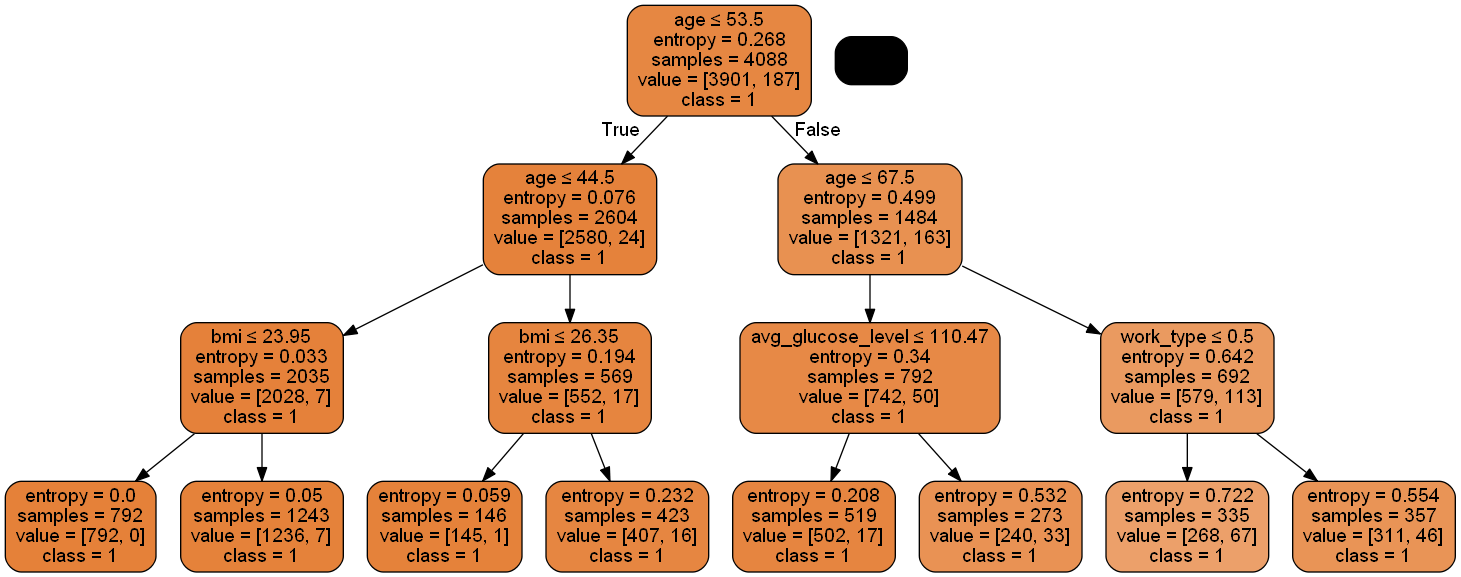

In [32]:
# Visualisasi pohon keputusan yang lebih baik
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

tree_stroke = StringIO()
export_graphviz(tree_datasets, out_file=tree_stroke, class_names=["1", "0"],
               feature_names=atr_datasets.columns, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(tree_stroke.getvalue())  
graph.write_png('stroke2.png')
Image(graph.create_png())